<a href="https://colab.research.google.com/github/jaolc/insurance-fraud-enb/blob/main/insu_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Settings

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import dedent
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, average_precision_score, brier_score_loss, precision_recall_curve,
                             confusion_matrix, silhouette_score, r2_score, roc_auc_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor


from sklearn.base import clone
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance


import xgboost as xgb
import lightgbm as lgb

import warnings, logging
warnings.filterwarnings("ignore")

from scipy.stats import spearmanr

import shap
import matplotlib as mpl


# Data Load, Settings

In [37]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random_state=RANDOM_STATE
test_size=0.3
plt.style.use("seaborn-v0_8-whitegrid")

In [38]:
# Cost-Benefit Scenarios
scenarios = {
    "Base":           {"r": 4000, "c": 400},
}

b_scenario = scenarios["Base"]

In [39]:
file_path = '/content/drive/MyDrive/Worksheet in Case Study question 2.xlsx'
df = pd.read_excel(file_path)
print(df.shape)
df.head(2)

(1000, 39)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y


# Data Preprocessing

In [40]:
# target mapping

y = df['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

# drop columns - (id/ high leakage risk /location-related columns)
drop_like = ['policy_number','incident_location','incident_city','insured_zip','policy_state','incident_state'
            ]
to_drop = [c for c in df.columns if any(k in c.lower() for k in drop_like)]
X = df.drop(columns=to_drop + ['fraud_reported'], errors='ignore').copy()
#print("Dropped:", to_drop)

Dropped: ['policy_number', 'policy_state', 'insured_zip', 'incident_state', 'incident_city', 'incident_location']


We audited the raw schema and confirmed that the dataset does not contain post-outcome fields such as claim status, settlement or investigator notes. Consequently, no such fields were used.

Our modelling rule excluded any post-claim or resolution variables (if present) to prevent leakage and to reflect information available at first notice of loss (FNOL).

Location-like identifiers (ZIP/state/city) were also excluded to avoid dataset-specific biases, focusing instead on claimant, policy and incident descriptors.

In [41]:
# date
X['incident_month'] = pd.to_datetime(X['incident_date']).dt.month
X['incident_day_of_week'] = pd.to_datetime(X['incident_date']).dt.dayofweek

def to_dt(s): return pd.to_datetime(s, errors="coerce")

# date
if {'policy_bind_date','incident_date'}.issubset(X.columns):
    X['policy_bind_date'] = to_dt(X['policy_bind_date'])
    X['incident_date']    = to_dt(X['incident_date'])
    X['policy_tenure_days'] = (X['incident_date'] - X['policy_bind_date']).dt.days
    X = X.drop(columns=['policy_bind_date','incident_date'])

# amount
if {'total_claim_amount','policy_annual_premium'}.issubset(X.columns):
    X['claim_to_premium_ratio'] = X['total_claim_amount'] / (X['policy_annual_premium'] + 1e-6)

# '?' → NaN
X = X.replace('?', np.nan)

In [42]:
# Ordinal mapping
ordinal_cols = ['incident_severity']
ordinal_categories = [['Trivial Damage','Minor Damage','Major Damage','Total Loss']]

#Numeric & Categorical
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

categorical_cols = [c for c in categorical_cols if c not in ordinal_cols]

# === 3. Pipelines ===
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

ord_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(categories=ordinal_categories,
                           handle_unknown="use_encoded_value", unknown_value=-1))
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# === 4. ColumnTransformer ===
pre = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("ord", ord_pipe, ordinal_cols),
    ("cat", cat_pipe, categorical_cols)
], remainder="drop", verbose_feature_names_out=False)

# EDA

In [43]:
df_eda = df.copy()
df_eda["_label"] = y.values
df_eda = df_eda.replace("?", np.nan)

# (incident_month, day_of_week, policy_tenure_days)
def to_dt(s): return pd.to_datetime(s, errors="coerce")
if {"policy_bind_date","incident_date"}.issubset(df_eda.columns):
    df_eda["policy_bind_date"] = to_dt(df_eda["policy_bind_date"])
    df_eda["incident_date"]    = to_dt(df_eda["incident_date"])
    df_eda["policy_tenure_days"] = (df_eda["incident_date"] - df_eda["policy_bind_date"]).dt.days

# claim-premium ratio
if {"total_claim_amount","policy_annual_premium"}.issubset(df_eda.columns):
    df_eda["claim_to_premium_ratio"] = (
        df_eda["total_claim_amount"] / (df_eda["policy_annual_premium"] + 1e-6)
    )


cont_cols = ["total_claim_amount", "policy_tenure_days", "claim_to_premium_ratio"]
cat_cols  = ["incident_severity", "authorities_contacted", "property_damage"]


cont_cols = [c for c in cont_cols if c in df_eda.columns]
cat_cols  = [c for c in cat_cols if c in df_eda.columns]

means = (df_eda.groupby("_label")[cont_cols]
         .mean()
         .rename(index={0:"Non-Fraudulent",1:"Fraudulent"}))

def _mode(s):
    x = s.dropna().astype(str)
    return x.mode().iloc[0] if not x.mode().empty else ""

modes = {
    c: (df_eda.groupby("_label")[c].agg(_mode)
        .rename(index={0:"Non-Fraudulent",1:"Fraudulent"}))
    for c in cat_cols
}

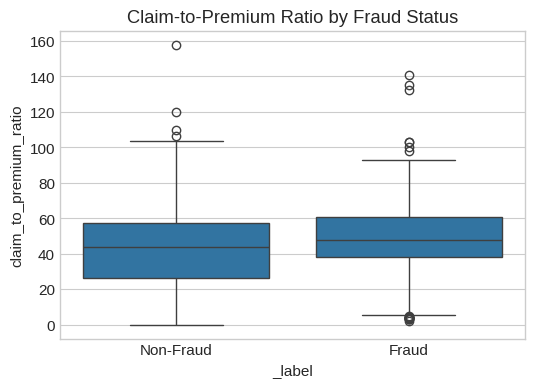

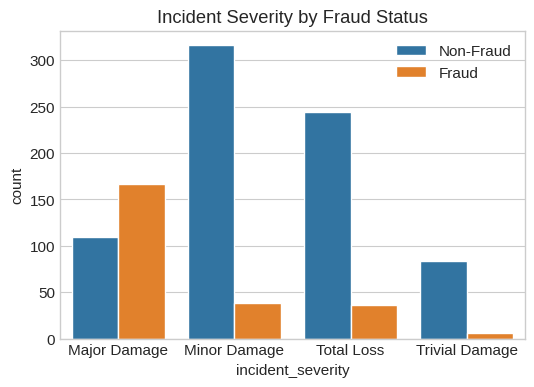

In [44]:
# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x="_label", y="claim_to_premium_ratio", data=df_eda)
plt.xticks([0,1], ["Non-Fraud", "Fraud"])
plt.title("Claim-to-Premium Ratio by Fraud Status")
plt.savefig("fig_claim_ratio_box.png", dpi=300, bbox_inches="tight")

# Barplot
plt.figure(figsize=(6,4))
sns.countplot(x="incident_severity", hue="_label", data=df_eda)
plt.legend(labels=["Non-Fraud","Fraud"])
plt.title("Incident Severity by Fraud Status")
plt.savefig("fig_incident_severity.png", dpi=300, bbox_inches="tight")

Only ***incident_severity*** was treated as ordinal using the natural order (“Trivial” < “Minor” < “Major” < “Total”). All other categorical variables were one-hot encoded to avoid imposing an artificial order.

To prevent data leakage, all preprocessing (including imputation of missing values) was embedded inside a scikit-learn pipeline. Median values for numerical features and modes for categorical features were calculated exclusively on the training folds during cross-validation, and then applied to the test data. This ensures that the model is not exposed to any information from the test set during training, which would otherwise inflate performance metrics.

# Model Training

In [45]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
)
print(X_train_raw.shape, X_test_raw.shape, y_train.mean().round(3))

(700, 34) (300, 34) 0.247


In [46]:
neg, pos = (y_train==0).sum(), (y_train==1).sum()
spw = max(1.0, neg/max(pos,1))

models = {
    "Logit":  LogisticRegression(max_iter=2000, class_weight="balanced"),
    "XGB":    xgb.XGBClassifier(
                objective='binary:logistic', eval_metric='logloss',
                n_estimators=400, learning_rate=0.05, max_depth=5,
                subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                random_state=RANDOM_STATE, scale_pos_weight=spw),
    "LGBM":   lgb.LGBMClassifier(
                n_estimators=600, learning_rate=0.05, num_leaves=31,
                subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                random_state=RANDOM_STATE, class_weight={0:1,1:spw},verbosity=-1)
}

We did not use oversampling in the main analysis; instead, we applied class weights (scale_pos_weight for gradient boosting; class_weight="balanced" for logistic regression)

In [47]:
# cast mixed-type columns to string
for col in X_train_raw.columns:
    if X_train_raw[col].dtype == 'object':
        X_train_raw[col] = X_train_raw[col].astype(str)
    if col in X_test_raw.columns:
        if X_test_raw[col].dtype == 'object':
            X_test_raw[col] = X_test_raw[col].astype(str)

suspects = ["witnesses", "bodily_injuries", "property_damage", "collision_type"]
for col in suspects:
    if col in X_train_raw.columns:
        X_train_raw[col] = X_train_raw[col].astype(str)
    if col in X_test_raw.columns:
        X_test_raw[col] = X_test_raw[col].astype(str)

In [48]:
def expected_nb_curve(y, p,r = b_scenario["r"], c =b_scenario["c"] , n=201):
    ts = np.linspace(0,1,n); out=[]
    for t in ts:
        m = p >= t
        out.append((t, float((p[m]*r).sum() - m.sum()*c)))
    df = pd.DataFrame(out, columns=["threshold","enb"])
    i = df["enb"].idxmax()
    return df, float(df.loc[i,"threshold"]), float(df.loc[i,"enb"])

def topk_table(y_true, proba, ks=(50,100,200)):
    order = np.argsort(-proba)
    y_sorted = y_true.values[order]
    P = max(1,(y_true==1).sum())
    out=[]
    for K in ks:
        K=min(K,len(y_true))
        tp = int((y_sorted[:K]==1).sum()); fp = K - tp
        out.append({"K":K,"TP":tp,"FP":fp,"Precision":tp/max(K,1),"Recall":tp/P})
    return pd.DataFrame(out)

In [49]:
results = {}
best_name, best_ap = None, -1


for name, clf in models.items():
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    pipe.fit(X_train_raw, y_train)
    p = pipe.predict_proba(X_test_raw)[:,1]

    ap    = average_precision_score(y_test, p)
    brier = brier_score_loss(y_test, p)
    nb, t_star, nb_max = expected_nb_curve(y_test, p, r=b_scenario["r"], c=b_scenario["c"])
    tk = topk_table(y_test, p)

    results[name] = {"PR_AUC":ap, "Brier":brier, "BestThr":t_star, "MaxENB":nb_max,
                     "TopK":tk, "proba":p, "pipe":pipe, "nb":nb}
    if ap > best_ap:
        best_ap, best_name = ap, name

summary = pd.DataFrame({k:{'PR_AUC':v['PR_AUC'], 'Brier':v['Brier'],
                           'BestThr':v['BestThr'], 'MaxENB':v['MaxENB']}
                        for k,v in results.items()}).T.sort_values("PR_AUC", ascending=False)


best_name = max(results, key=lambda k: results[k]["PR_AUC"])

print("=== Summary ===")
print(summary.round(4))
print("Best model:", best_name)


=== Summary ===
       PR_AUC   Brier  BestThr       MaxENB
LGBM   0.6029  0.1376    0.095  228396.0004
XGB    0.5736  0.1347    0.100  222879.1562
Logit  0.4064  0.2319    0.100  379617.5654
Best model: LGBM


라텍스용코드

In [50]:
# pretty latex

def pretty_latex(df, fname, caption, label):
    df = df.copy()
    df.index.name = None
    df.columns = [str(c) for c in df.columns]  # multi-index 방지

    header = " & ".join([r"\textbf{"+c+r"}" for c in df.columns]) + r" \\"
    lines = [r"\begin{table}[h]",
             r"\centering",
             r"\begin{tabular}{"+ "l" * (1 if df.index.name else 0) + "r"*len(df.columns) + r"}",
             r"\hline\hline",
             header,
             r"\hline"]
    for _, row in df.iterrows():
        vals = " & ".join(row.astype(str).tolist())
        lines.append(vals + r" \\")
    lines += [r"\hline\hline",
              r"\end{tabular}",
              fr"\caption{{{caption}}}",
              fr"\label{{{label}}}",
              r"\end{table}"]
    with open(fname, "w") as f:
        f.write("\n".join(lines))



=== [Table MS-1] Model Comparison (test set) ===
   Model  ROC_AUC  PR_AUC   Brier  τ* (ENB-max)  ENB_max (£)  Precision@τ*  \
2   LGBM   0.8266  0.6029  0.1376         0.095  228396.0004        0.6316   
1    XGB   0.8277  0.5736  0.1347         0.100  222879.1562        0.5575   
0  Logit   0.6494  0.4064  0.2319         0.100  379617.5654        0.2586   

   Recall@τ*   F1@τ*  Specificity@τ*  Accuracy@τ*  Precision@K=100  \
2     0.8108  0.7101          0.8451       0.8367             0.61   
1     0.8514  0.6738          0.7788       0.7967             0.60   
0     0.9189  0.4036          0.1372       0.3300             0.34   

   Recall@K=100  ENB@K=100 (£)  
2        0.8243    228187.1509  
1        0.8108    221539.8254  
0        0.4595    255760.9309  


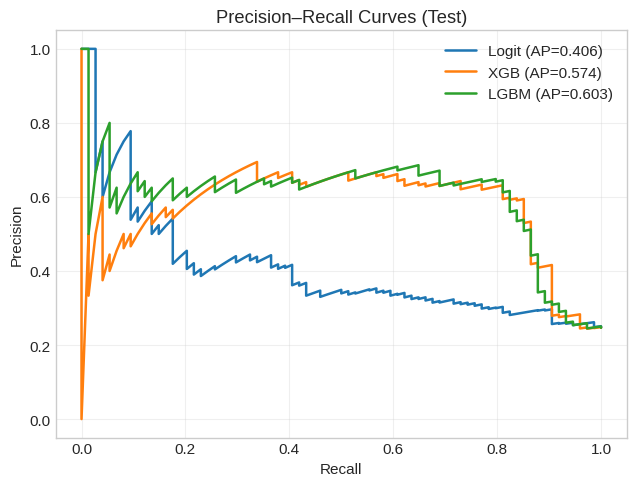

In [51]:
K_FOR_TABLE = 100

rows = []
pr_curves = {}  # for plotting

for name, res in results.items():
    p = res["proba"]
    roc = roc_auc_score(y_test, p)
    ap  = res["PR_AUC"]
    brier = res["Brier"]
    tstar = float(res["BestThr"])
    enb_max = float(res["MaxENB"])


    pred = (p >= tstar).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    precision_tau = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall_tau    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity   = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    accuracy      = (tp + tn) / len(y_test)
    f1_tau        = (2 * precision_tau * recall_tau) / (precision_tau + recall_tau) if (precision_tau + recall_tau) > 0 else 0.0

    # Top-K(K=100)
    df_rank = pd.DataFrame({"p": p, "y": y_test}).sort_values("p", ascending=False)
    K = min(K_FOR_TABLE, len(df_rank))
    topk = df_rank.head(K)
    prec_at_k = float(topk["y"].sum()) / K if K > 0 else 0.0
    rec_at_k  = float(topk["y"].sum()) / float(y_test.sum()) if y_test.sum() > 0 else 0.0
    enb_at_k  = b_scenario["r"] * float(topk["p"].sum()) - b_scenario["c"] * K

    rows.append({
        "Model": name,
        "ROC_AUC": roc,
        "PR_AUC": ap,
        "Brier": brier,
        "τ* (ENB-max)": tstar,
        "ENB_max (£)": enb_max,
        "Precision@τ*": precision_tau,
        "Recall@τ*": recall_tau,
        "F1@τ*": f1_tau,
        "Specificity@τ*": specificity,
        "Accuracy@τ*": accuracy,
        f"Precision@K={K_FOR_TABLE}": prec_at_k,
        f"Recall@K={K_FOR_TABLE}": rec_at_k,
        f"ENB@K={K_FOR_TABLE} (£)": enb_at_k,
    })

    # PR curve (for combined plot)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, p)
    pr_curves[name] = (rec_curve, prec_curve)


ms_table = pd.DataFrame(rows).sort_values(["PR_AUC","ROC_AUC"], ascending=False)
print("\n=== [Table MS-1] Model Comparison (test set) ===")
print(ms_table.round(4))

plt.figure(figsize=(6.5, 5))
for name, (rc, pr) in pr_curves.items():
    plt.plot(rc, pr, lw=1.8, label=f"{name} (AP={results[name]['PR_AUC']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Test)")
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.savefig("prauc.png", dpi=300)
plt.show()

In [52]:
#TRUTH
best = results[best_name]
p_best = best["proba"]
pipeline_best = best["pipe"]
ap_best = best["PR_AUC"]
brier_best = best["Brier"]

pre = pipe.named_steps["pre"]
clf = pipe.named_steps["clf"]

In [53]:
#Feature Importance
try:
    feat_names = pre.get_feature_names_out()
except:
    feat_names = np.arange(pre.transform(X_train_raw).shape[1]).astype(str)
try:
    importances = pipe.named_steps["clf"].feature_importances_
    fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
    print(fi.head(20))
except Exception as e:
    print("Feature importance not available:", e)

                      feature  importance
3       policy_annual_premium         820
13             property_claim         763
18         policy_tenure_days         747
0          months_as_customer         696
12               injury_claim         675
14              vehicle_claim         663
19     claim_to_premium_ratio         630
15                  auto_year         574
20          incident_severity         565
7    incident_hour_of_the_day         539
11         total_claim_amount         480
5               capital-gains         432
6                capital-loss         429
1                         age         416
52      insured_hobbies_chess         362
53  insured_hobbies_cross-fit         323
17       incident_day_of_week         279
10                  witnesses         186
9             bodily_injuries         158
2           policy_deductable         153


The model’s feature importance aligns closely with intuitive fraud indicators used in practice. Premium-related features (policy_annual_premium, claim_to_premium_ratio, policy_tenure_days) dominate, reflecting insurers’ concern with disproportionate claims relative to paid premium and unusually short policy durations. Claim composition variables (property_claim, injury_claim, vehicle_claim) also emerge as top predictors, consistent with SIU heuristics that multiple simultaneous claims often indicate opportunistic fraud.
Operational factors (incident_severity, incident_hour_of_the_day, incident_day_of_week, auto_year) are likewise highly ranked, suggesting that the model learned to replicate known red flags such as late-night collisions or claims on older vehicles.
Some demographic or lifestyle variables (e.g., capital-gains, capital-loss, certain hobbies) appear in the top 20 but may reflect dataset-specific artifacts rather than generalizable patterns. These should be interpreted with caution, underscoring the importance of external validation.

# shap plots

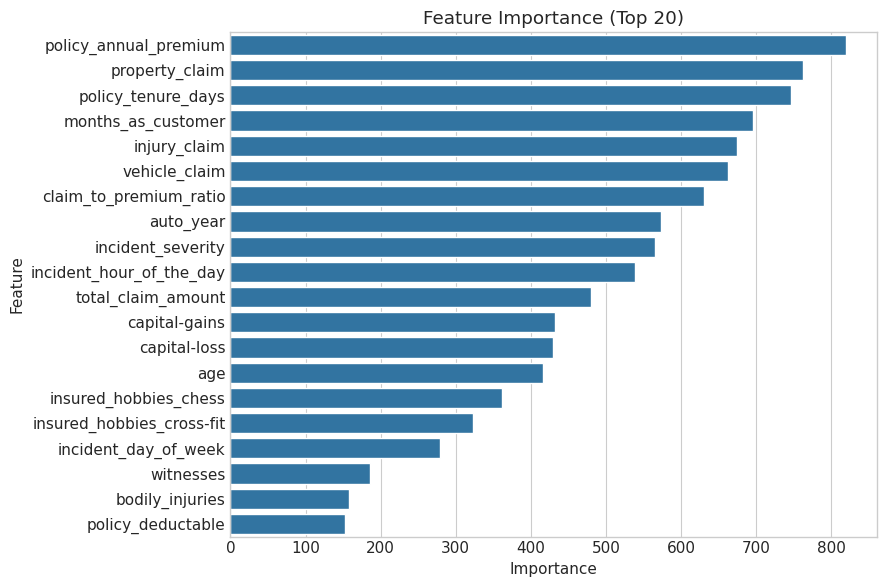

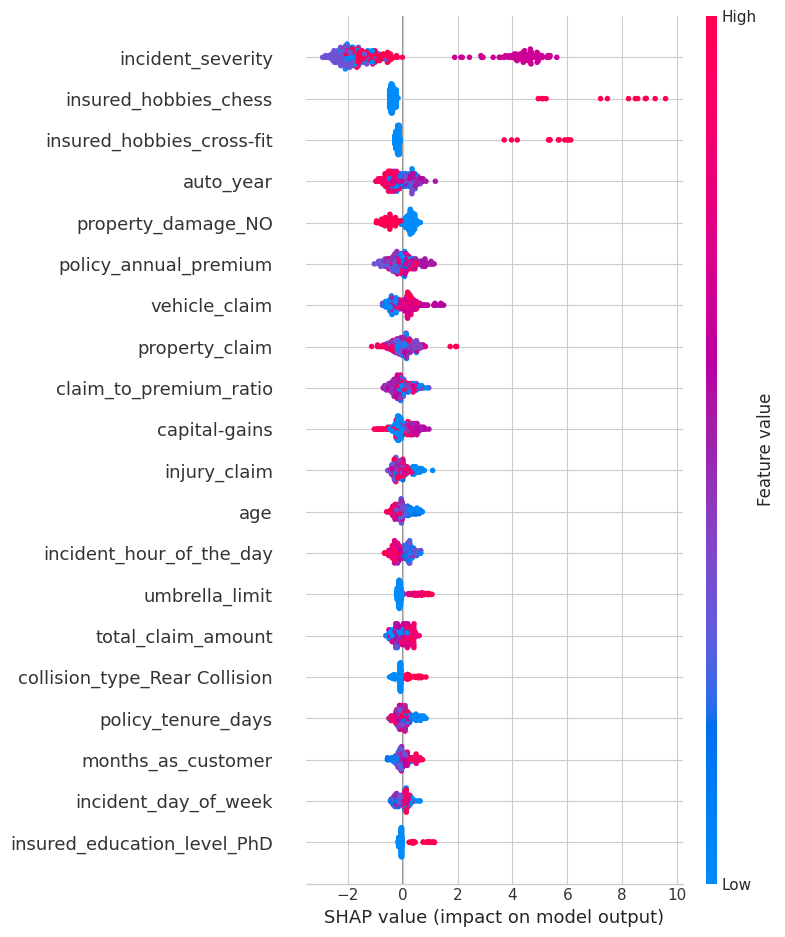

<Figure size 1000x400 with 0 Axes>

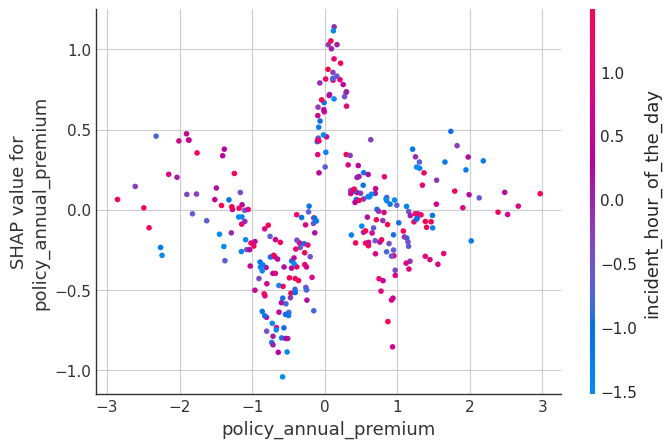

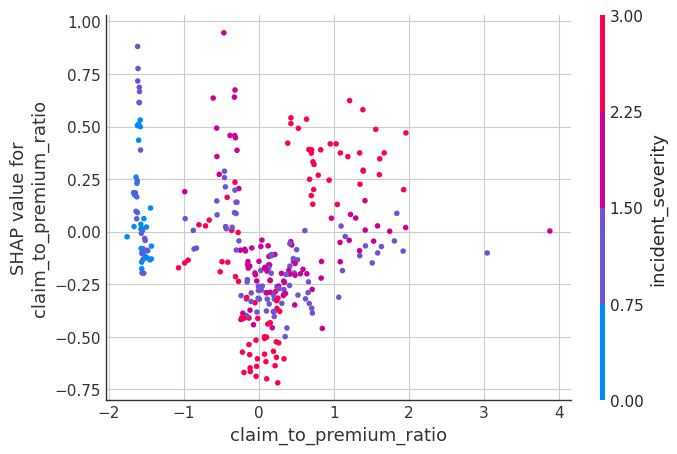

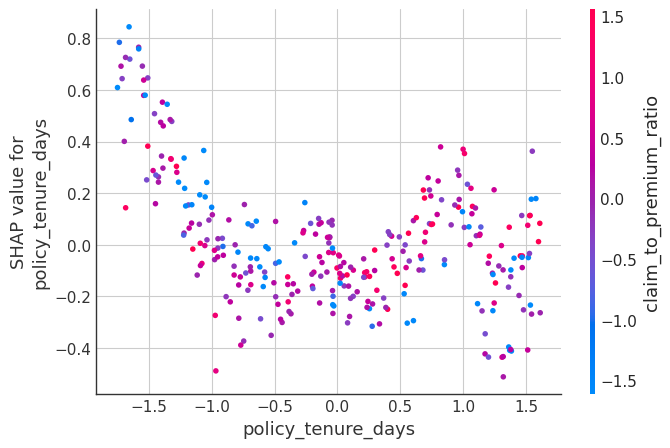

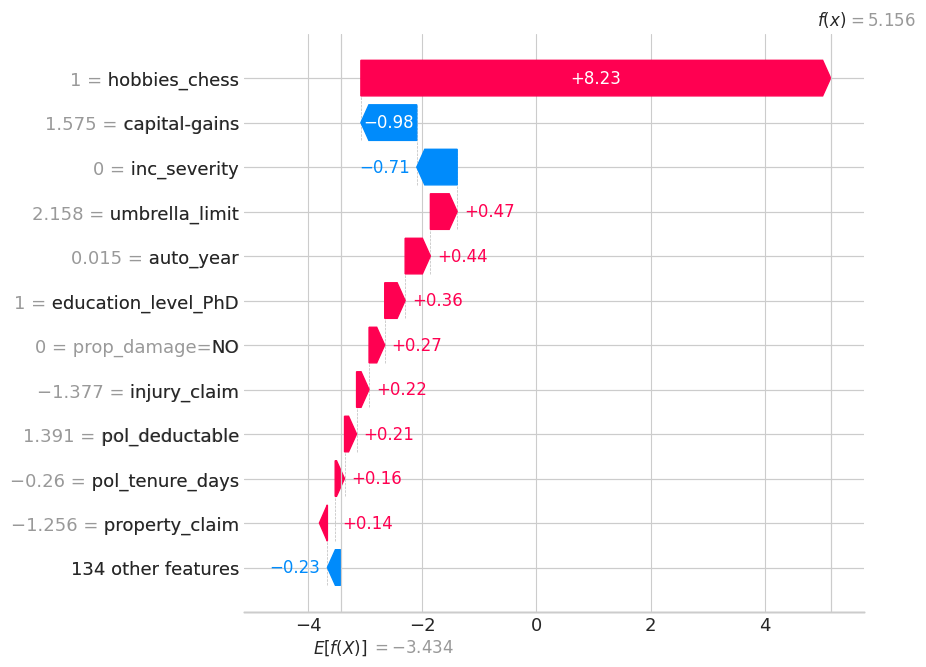

<Figure size 1000x400 with 0 Axes>

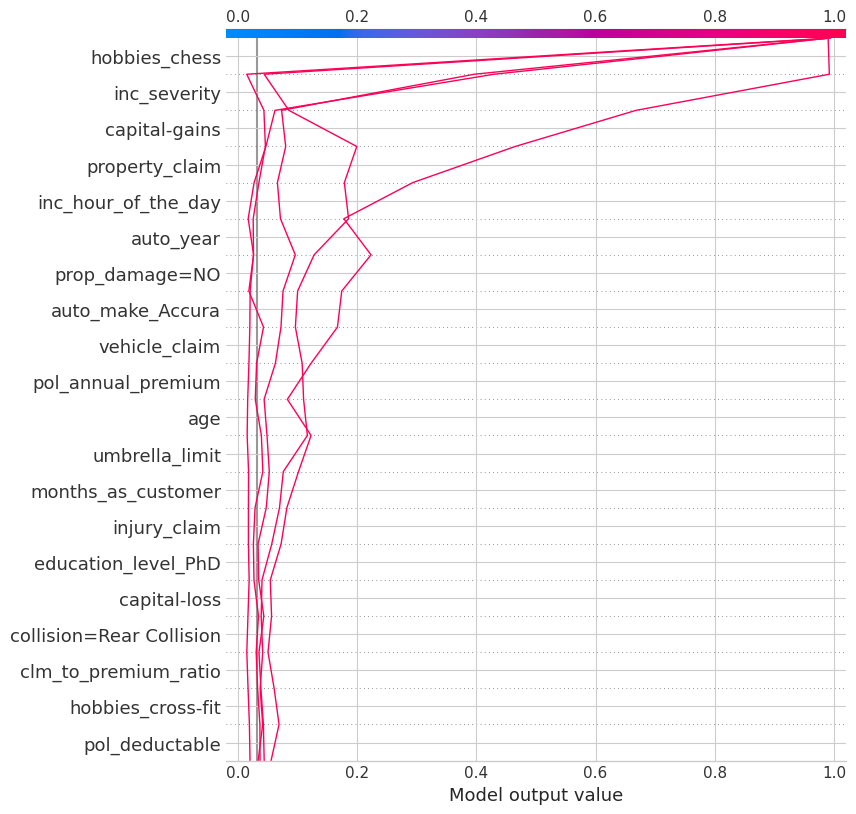

<Figure size 1000x400 with 0 Axes>

In [54]:
#shap
sns.set_style("whitegrid")


Xt = pre.transform(X_test_raw)   # numpy array
try:
    feat_names = pre.get_feature_names_out()
except:
    feat_names = np.arange(Xt.shape[1]).astype(str)

def _clean(n):
    s = str(n)
    return s.split("__",1)[1] if "__" in s else s
feat_names_clean = np.array([_clean(n) for n in feat_names])

# Feature importance (bar plot)
plt.figure(figsize=(9,6))
imp = pd.Series(clf.feature_importances_, index=feat_names_clean).sort_values(ascending=False)

top = imp.head(20)
sns.barplot(x=top.values, y=top.index)
plt.title("Feature Importance (Top 20)")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

# SHAP summary plot
if hasattr(clf, "predict_proba") and ("LGBM" in clf.__class__.__name__ or "XGB" in clf.__class__.__name__):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(Xt)
    sv = shap_values[1] if isinstance(shap_values, list) else shap_values
plt.figure(figsize=(10,5))
shap.summary_plot(sv, Xt, feature_names=feat_names_clean, show=True)
plt.tight_layout()
plt.savefig("fig_shap_summary.png", dpi=300, bbox_inches="tight")

# SHAP dependence plots
cand = ["policy_annual_premium", "claim_to_premium_ratio", "policy_tenure_days"]
dep_feats = [c for c in cand if any(feat_names_clean == c)]
color_by = {
    "policy_annual_premium": "incident_hour_of_the_day",
    "claim_to_premium_ratio": "incident_severity",
    "policy_tenure_days": "claim_to_premium_ratio",
}
for f in dep_feats:
    col = color_by.get(f, None)
    if col and any(feat_names_clean == col):
        shap.dependence_plot(f, sv, Xt, feature_names=feat_names_clean, interaction_index=col, show=True)
    else:
        shap.dependence_plot(f, sv, Xt, feature_names=feat_names_clean, show=True)


mpl.rcParams['figure.figsize'] = (10, 4)
mpl.rcParams['font.size'] = 11

def short_name(s: str) -> str:
    s = s.replace("insured_", "").replace("policy_", "pol_").replace("incident_", "inc_")
    s = s.replace("claim_", "clm_").replace("number_of_", "num_")
    s = s.replace("collision_type_", "collision=")
    s = s.replace("property_damage_", "prop_damage=")
    s = s.replace("insured_education_level_", "edu=")
    return s

feat_short = np.array([short_name(n) for n in feat_names_clean])

p = pipe.predict_proba(X_test_raw)[:,1]
idx = int(np.argmax(p))
sv_i = sv[idx]; x_i = Xt[idx]

# Get the expected value from the explainer
if hasattr(explainer, 'expected_value'):
    expv = explainer.expected_value
else:
    expv = 0.0


# Waterfall plot (12)
ex = shap.Explanation(values=sv_i, base_values=expv, data=x_i, feature_names=feat_short)
plt.figure(figsize=(10,5))
shap.plots.waterfall(ex, max_display=12, show=True)
plt.tight_layout()
plt.savefig("waterfall_top1.png", dpi=300, bbox_inches="tight")

# Decision plot
top5 = np.argsort(-p)[:5]
plt.figure(figsize=(10,5))
shap.decision_plot(expv, sv[top5], Xt[top5], feature_names=feat_short,
                   feature_order='importance', link='logit', show=True)
plt.tight_layout()
plt.savefig("decision_top5.png", dpi=300, bbox_inches="tight")

robust check

In [55]:
#robut
#to str
for col in X.select_dtypes(include=["object", "category"]).columns:
    X[col] = X[col].astype(str)

# (1) original model
Xt = pre.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

pipe_full = Pipeline([("pre", pre), ("clf", clone(clf))])
pipe_full.fit(X_train, y_train)

y_pred_full = pipe_full.predict_proba(X_test)[:, 1]


print("Full Feature Set")
print(" ROC-AUC:", roc_auc_score(y_test, y_pred_full))
print(" PR-AUC :", average_precision_score(y_test, y_pred_full))

# # suspect feature drop
hobby_cols = [c for c in X.columns if "insured_hobbies" in c.lower()]
X_reduced = X.drop(columns=hobby_cols, errors="ignore")

# ColumnTransformer (excl. hobbies)
categorical_cols = [c for c in X_reduced.columns if X_reduced[c].dtype == "object"]
numeric_cols = [c for c in X_reduced.columns if X_reduced[c].dtype != "object"]

pre_reduced = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])

pipe_reduced = Pipeline([("pre", pre_reduced), ("clf", lgb.LGBMClassifier(class_weight="balanced", random_state=42))])

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced, y, test_size=0.3, stratify=y, random_state=42
)

pipe_reduced.fit(X_train_r, y_train_r)
y_pred_red = pipe_reduced.predict_proba(X_test_r)[:, 1]

print("Reduced Feature Set")
print(" ROC-AUC:", roc_auc_score(y_test_r, y_pred_red))
print(" PR-AUC :", average_precision_score(y_test_r, y_pred_red))

Full Feature Set
 ROC-AUC: 0.8265965080124373
 PR-AUC : 0.6029131592019736
Reduced Feature Set
 ROC-AUC: 0.7651279598182252
 PR-AUC : 0.5043240579025775


ROC-AUC: 0.8265965080124373
 PR-AUC : 0.6029131592019736

# Cost–Benefit Operating Point & Capacity Planning (MAIN)







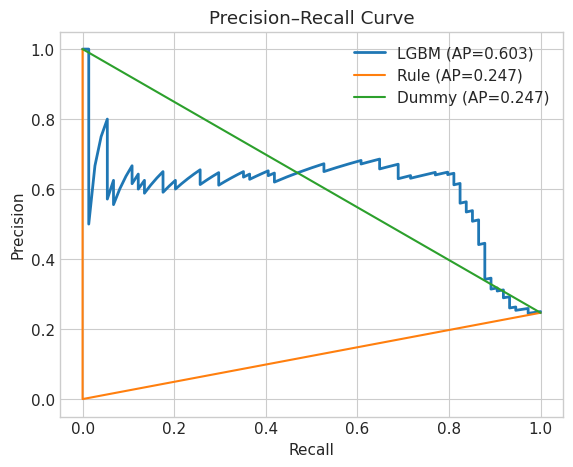

In [56]:

#Dummy = constant prevalence
#Rule = simple heuristic, optional
prev = y_test.mean()
p_dummy = np.full_like(p_best, fill_value=prev, dtype=float)
ap_dummy = average_precision_score(y_test, p_dummy)

# rule
rule = np.zeros_like(p_best)
if "claim_to_premium_ratio" in X_test_raw.columns:
    rule += (X_test_raw["claim_to_premium_ratio"].fillna(0) > 1.2).astype(float).values
if "policy_tenure_days" in X_test_raw.columns:
    rule += (X_test_raw["policy_tenure_days"].fillna(0) < 60).astype(float).values
p_rule = (rule - rule.min()) / (rule.max() - rule.min()) if rule.max() > rule.min() else rule
ap_rule = average_precision_score(y_test, p_rule)

# PR curve
prec_b, rec_b, _ = precision_recall_curve(y_test, p_best)
prec_r, rec_r, _ = precision_recall_curve(y_test, p_rule)
prec_d, rec_d, _ = precision_recall_curve(y_test, p_dummy)

plt.figure(figsize=(6.5,5))
plt.plot(rec_b, prec_b, lw=2, label=f'{best_name} (AP={ap_best:.3f})')
plt.plot(rec_r, prec_r, lw=1.5, label=f'Rule (AP={ap_rule:.3f})')
plt.plot(rec_d, prec_d, lw=1.5, label=f'Dummy (AP={ap_dummy:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curve'); plt.legend(); plt.show()



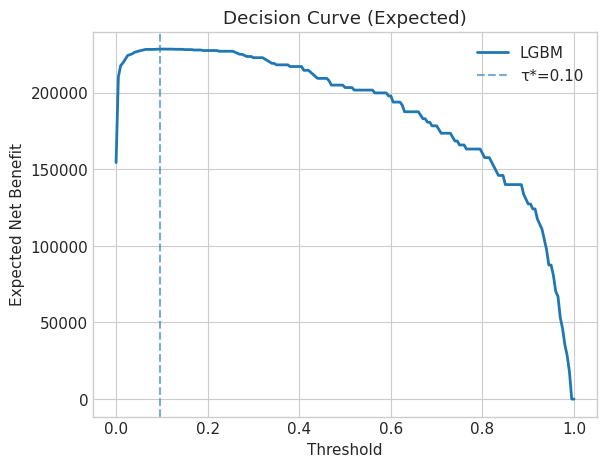

Best threshold (ENB): τ*=0.095, ENB=228,396.0


,Threshold (τ),Flagged (N),TP (Frauds Found),FP,Expected Recovery (£),Investigation Cost (£),ENB (£)
0,0.010,138,64,74,272813.0,55200.0,217613.0
1,0.050,106,61,45,269536.0,42400.0,227136.0
2,0.095,95,60,35,266396.0,38000.0,228396.0
3,0.200,90,58,32,263452.0,36000.0,227452.0
4,0.300,83,53,30,255985.0,33200.0,222785.0


In [57]:
nb_df, tau_star, enb_max = expected_nb_curve(y_test, p_best, r = b_scenario["r"], c= b_scenario["c"])
plt.figure(figsize=(6.5,5))
plt.plot(nb_df["threshold"], nb_df["enb"], lw=2, label=f'{best_name}')
plt.axvline(tau_star, ls='--', alpha=.6, label=f'τ*={tau_star:.2f}')
plt.xlabel('Threshold'); plt.ylabel('Expected Net Benefit'); plt.title('Decision Curve (Expected)'); plt.legend(); plt.show()
print(f"Best threshold (ENB): τ*={tau_star:.3f}, ENB={enb_max:,.1f}")



y_true = y_test.values
y_prob = p_best
BASE_R = b_scenario["r"]
BASE_C = b_scenario["c"]
taus_sel = [0.01, 0.05, 0.095, 0.20, 0.30]

rows = []
for t in taus_sel:
    flag = (y_prob >= t)
    flagged_n = int(flag.sum())

    if flagged_n == 0:
        exp_rec = inv_cost = enb = 0.0
        tp = fp = 0
    else:
        exp_rec = float(BASE_R * y_prob[flag].sum())     # r
        inv_cost = float(BASE_C * flagged_n)             # c
        enb = exp_rec - inv_cost
        tn, fp, fn, tp = confusion_matrix(y_true, flag.astype(int)).ravel()

    rows.append({
        "Threshold (τ)": t,
        "Flagged (N)": flagged_n,
        "TP (Frauds Found)": int(tp),
        "FP": int(fp),
        "Expected Recovery (£)": exp_rec,
        "Investigation Cost (£)": inv_cost,
        "ENB (£)": enb
    })

thr5 = pd.DataFrame(rows)
thr5_round = thr5.copy()
thr5_round[["Expected Recovery (£)", "Investigation Cost (£)", "ENB (£)"]] = \
    thr5_round[["Expected Recovery (£)", "Investigation Cost (£)", "ENB (£)"]].round(0)
def fmt_int(x):
    return f"{int(round(x,0)):,}"

thr5_fmt = thr5.copy()
for col in ["Expected Recovery (£)", "Investigation Cost (£)", "ENB (£)"]:
    thr5_fmt[col] = thr5_fmt[col].apply(fmt_int)

#def _pretty_latex(df, caption, label, align=None):


latex_str = pretty_latex(
        thr5_fmt.rename(columns={
            "Threshold (τ)":"τ",
            "Flagged (N)":"Flagged (N)",
            "TP (Frauds Found)":"TP (Frauds Found)",
            "FP":"FP (False Alarms)",
            "Expected Recovery (£)":"Expected Recovery (£)",
            "Investigation Cost (£)":"Investigation Cost (£)",
            "ENB (£)":"ENB (£)"
        }),
        caption="Threshold sweep under the base scenario (expected-value ENB).",
        label="tab:threshold_sweep",
        fname = "tab_threshold_sweep.tex",
    )


thr5_round.head()


# Sensitivity Check: ENB grid & top-k

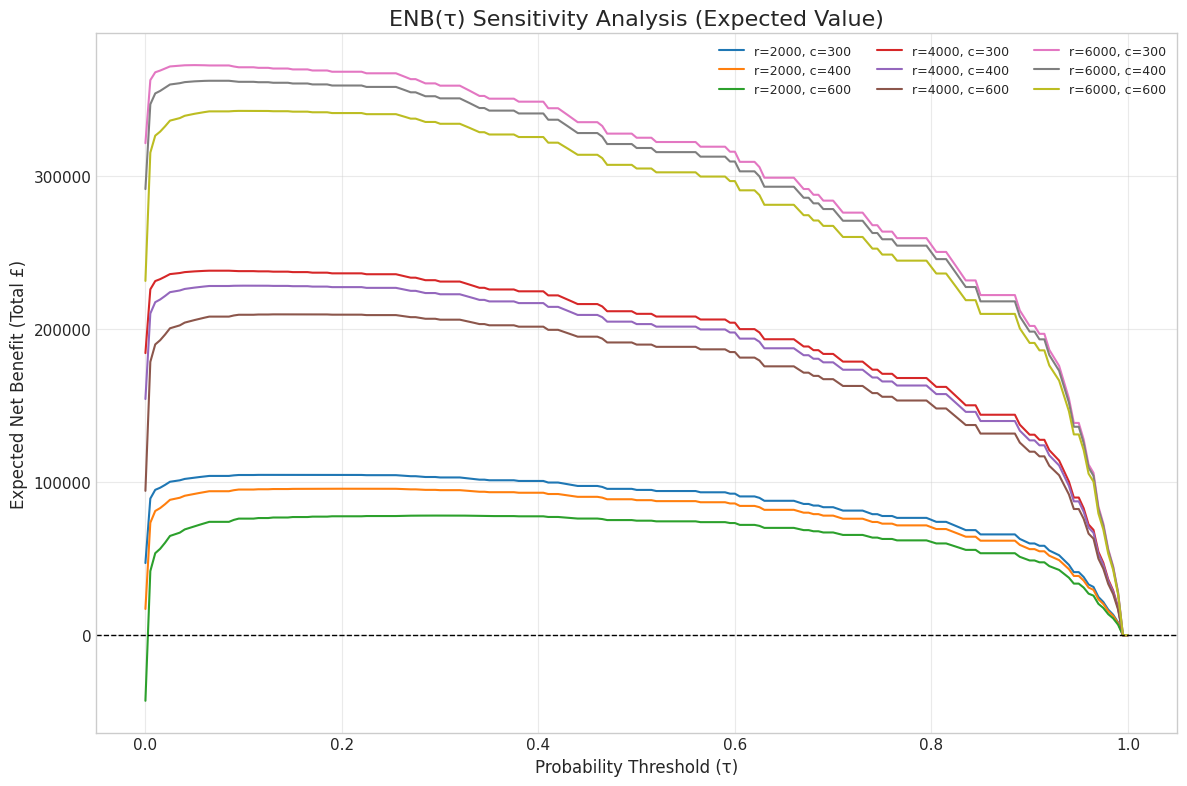

In [58]:
# A. Cost–Benefit Operating Point & Capacity Planning  (FINAL, Uncal)
# Expected ENB: ENB(τ) = r * Σ_{p_i≥τ} p_i  −  c * #(p_i≥τ)

BASE_R = b_scenario["r"]
BASE_C = b_scenario["c"]

# 1) Threshold grid
thresholds = np.linspace(0.0, 1.0, 201)

# 2) ENB(τ) Expected value
r_values = [2000, 4000, 6000]
c_values = [300, 400, 600]
sensitivity_rows = []

plt.figure(figsize=(12, 8))

for r in r_values:
    for c in c_values:
        enb_curve = []
        for t in thresholds:
            mask = (p_best >= t)
            # 기대 회수액: r * 확률합, 조사비: c * 선택건수
            enb_t = r * float(p_best[mask].sum()) - c * int(mask.sum())
            enb_curve.append(enb_t)

        enb_curve = np.asarray(enb_curve)
        idx_max = int(enb_curve.argmax())
        t_star  = float(thresholds[idx_max])
        enb_max = float(enb_curve[idx_max])

        sensitivity_rows.append({
            'r (Recovery)': r,
            'c (Cost)': c,
            'c/r Ratio': round(c/r, 3),
            'Optimal Threshold (τ*)': t_star,
            'Max ENB (expected)': enb_max
        })

        plt.plot(thresholds, enb_curve, label=f"r={r}, c={c}")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('ENB(τ) Sensitivity Analysis (Expected Value)', fontsize=16)
plt.xlabel('Probability Threshold (τ)', fontsize=12)
plt.ylabel('Expected Net Benefit (Total £)', fontsize=12)
plt.legend(ncol=3, fontsize=9)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig("enb_sensitivity_curve_expected.png", dpi=300)
plt.show()



# Top-K

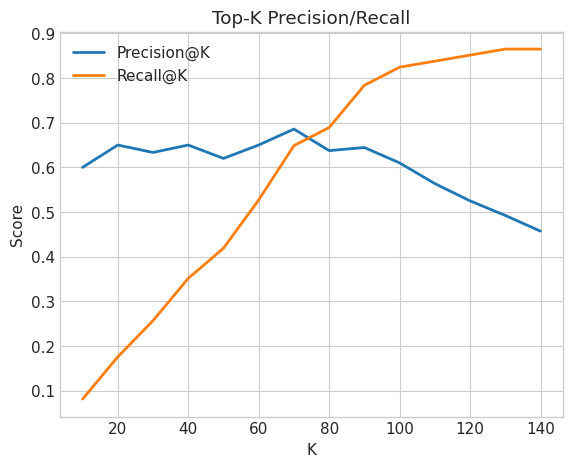

     K  TP  FP  Precision    Recall
0   10   6   4   0.600000  0.081081
1   20  13   7   0.650000  0.175676
2   30  19  11   0.633333  0.256757
3   40  26  14   0.650000  0.351351
4   50  31  19   0.620000  0.418919
5   60  39  21   0.650000  0.527027
6   70  48  22   0.685714  0.648649
7   80  51  29   0.637500  0.689189
8   90  58  32   0.644444  0.783784
9  100  61  39   0.610000  0.824324

--- [Table S2-2] Top-K Capacity Planning (Expected Value) ---
   Capacity (K)  Frauds Found (TP)  False Alarms (FP)  Precision@K  Recall@K  \
0            25                 15                 10       0.6000    0.2027   
1            50                 31                 19       0.6200    0.4189   
2            75                 50                 25       0.6667    0.6757   
3           100                 61                 39       0.6100    0.8243   
4           125                 64                 61       0.5120    0.8649   
5           150                 65                 85       0

In [59]:
# 4) Top-K Capacity Planning

def topk_points(y, p, k_grid=None):
    if k_grid is None:
        k_grid = list(range(10, min(400, len(y)//2), 10))
    order = np.argsort(-p)
    y_sorted = y.values[order]
    P = max(1, (y==1).sum())
    rows=[]
    for K in k_grid:
        K = min(K, len(y))
        tp = int((y_sorted[:K]==1).sum()); fp = K - tp
        rows.append((K, tp, fp, tp/max(K,1), tp/P))
    return pd.DataFrame(rows, columns=["K","TP","FP","Precision","Recall"])

tk_df = topk_points(y_test, p_best)
plt.figure(figsize=(6.5,5))
plt.plot(tk_df["K"], tk_df["Precision"], lw=2, label='Precision@K')
plt.plot(tk_df["K"], tk_df["Recall"],    lw=2, label='Recall@K')
plt.xlabel('K'); plt.ylabel('Score'); plt.title('Top-K Precision/Recall'); plt.legend(); plt.show()
print(tk_df.head(10))


sorted_df = pd.DataFrame({'proba': p_best, 'true': y_test}).sort_values('proba', ascending=False)
k_values = list(range(25, 226, 25))
topk_rows = []
P = int(y_test.sum())


for K in k_values:
    sub = sorted_df.head(K)
    tp_k = int(sub['true'].sum())
    fp_k = K - tp_k
    prec = tp_k / K
    rec  = tp_k / max(P, 1)
    enbK = BASE_R * float(sub['proba'].sum()) - BASE_C * K  # 기대값 ENB

    topk_rows.append({'Capacity (K)': K,
                      'Frauds Found (TP)': tp_k,
                      'False Alarms (FP)': fp_k,
                      'Precision@K': prec,
                      'Recall@K': rec,
                      'Expected Net Benefit': enbK})

top_k_df = pd.DataFrame(topk_rows)
print("\n--- [Table S2-2] Top-K Capacity Planning (Expected Value) ---")
print(top_k_df.round(4))


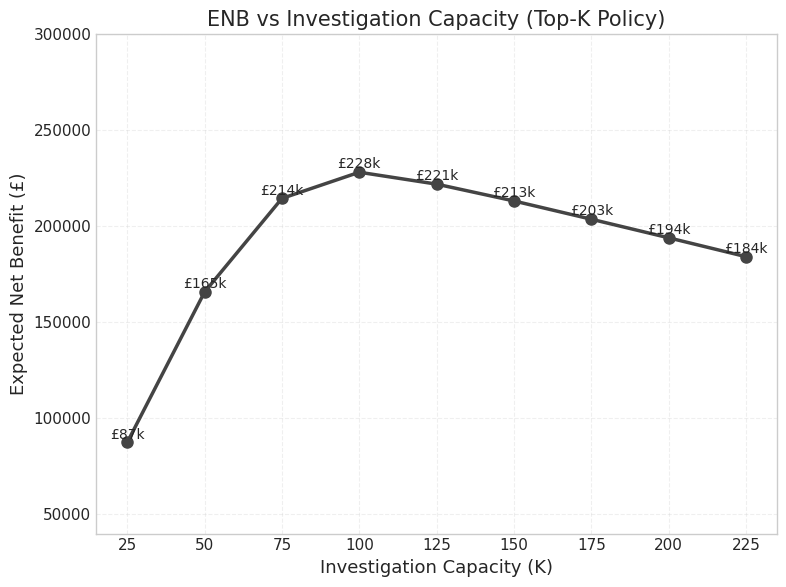

In [60]:

plt.figure(figsize=(8,6))
plt.plot(top_k_df["Capacity (K)"], top_k_df["Expected Net Benefit"],
         marker="o", markersize=8, linewidth=2.5, color="#444444")
for i, row in top_k_df.iterrows():
    plt.text(row["Capacity (K)"], row["Expected Net Benefit"]+2000,
             f"£{int(row['Expected Net Benefit']/1000)}k",
             ha="center", fontsize=10)

plt.title("ENB vs Investigation Capacity (Top-K Policy)", fontsize=15)
plt.xlabel("Investigation Capacity (K)", fontsize=13)
plt.ylabel("Expected Net Benefit (£)", fontsize=13)

#scope
plt.ylim(40000, 300000)

plt.grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.savefig("fig_topk.png", dpi=300)
plt.show()

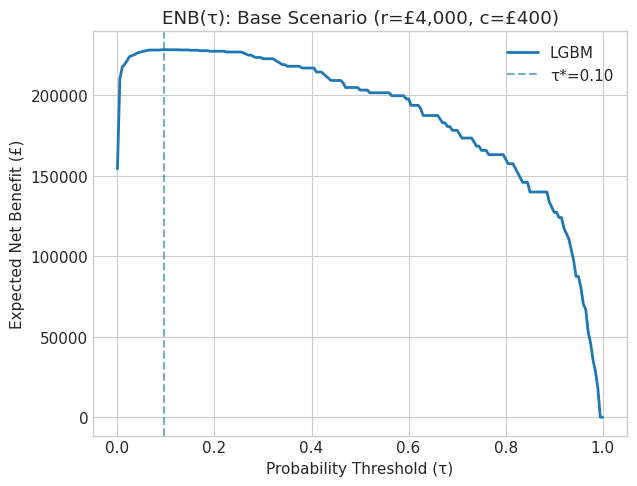

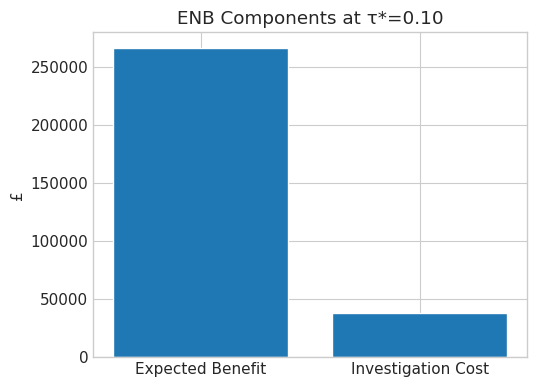


--- [Table S2-1] ENB Sensitivity Grid (Expected Value) ---
   r (Recovery)  c (Cost)  c/r Ratio  Optimal Threshold (τ*)  \
0          2000       300      0.150                   0.150   
1          2000       400      0.200                   0.190   
2          2000       600      0.300                   0.300   
3          4000       300      0.075                   0.065   
4          4000       400      0.100                   0.095   
5          4000       600      0.150                   0.150   
6          6000       300      0.050                   0.050   
7          6000       400      0.067                   0.065   
8          6000       600      0.100                   0.095   

   Max ENB (expected)  
0          104832.320  
1           95726.132  
2           78192.455  
3          238187.151  
4          228396.000  
5          209664.640  
6          372504.420  
7          362280.726  
8          342594.001  


In [61]:
#Base ENB curve
nb_df, tau_star, enb_max = expected_nb_curve(y_test, p_best, r=b_scenario["r"], c=b_scenario["c"])
plt.figure(figsize=(6.5,5))
plt.plot(nb_df["threshold"], nb_df["enb"], lw=2, label=f'{best_name}')
plt.axvline(tau_star, ls='--', alpha=.6, label=f'τ*={tau_star:.2f}')
plt.xlabel('Probability Threshold (τ)')
plt.ylabel('Expected Net Benefit (£)')
plt.title(f'ENB(τ): Base Scenario (r=£{b_scenario["r"]:,}, c=£{b_scenario["c"]:,})')
plt.legend(); plt.tight_layout()
plt.savefig("fig_R1_enb_curve_base.png", dpi=300)  # << 사용
plt.show()

# enb bar plot
flag = (p_best >= tau_star)
exp_benefit = b_scenario["r"] * float(p_best[flag].sum())
inv_cost    = b_scenario["c"] * int(flag.sum())

plt.figure(figsize=(5.5,4))
plt.bar(["Expected Benefit", "Investigation Cost"], [exp_benefit, inv_cost])
plt.title(f"ENB Components at τ*={tau_star:.2f}")
plt.ylabel("£"); plt.tight_layout()
plt.savefig("fig_R3_enb_components_tstar.png", dpi=300)  # << 사용
plt.show()

# table
sensitivity_df = pd.DataFrame(sensitivity_rows)
print("\n--- [Table S2-1] ENB Sensitivity Grid (Expected Value) ---")
print(sensitivity_df.sort_values(['r (Recovery)','c (Cost)']).round(3))
sensitivity_df.to_csv("enb_sensitivity_grid_expected.csv", index=False)

#ENB grid
sens_df = (sensitivity_df
           .sort_values(['r (Recovery)','c (Cost)'])
           .rename(columns={
               "r (Recovery)": "Recovery (r)",
               "c (Cost)": "Cost (c)",
               "c/r Ratio": "c/r Ratio",
               "Optimal Threshold (τ*)": r"$\tau^\*$",
               "Max ENB (expected)": r"Max ENB (£)"
           })
          )


sens_df["c/r Ratio"] = sens_df["c/r Ratio"].map(lambda x: f"{x:.3f}")
sens_df[r"$\tau^\*$"] = sens_df[r"$\tau^\*$"].map(lambda x: f"{x:.3f}")
sens_df[r"Max ENB (£)"] = sens_df[r"Max ENB (£)"].map(lambda x: f"{x:,.0f}")


sens_df = sens_df[["Recovery (r)", "Cost (c)", "c/r Ratio", r"$\tau^\*$", r"Max ENB (£)"]]

# LaTeX
pretty_latex(sens_df,
             fname="tab_R2_enb_sensitivity.tex",
             caption="ENB(\\(\\tau\\)) sensitivity across recovery \\(r\\) and cost \\(c\\) scenarios (expected value).",
             label="tab:R2_enb_sensitivity")


In [62]:
BASE_R, BASE_C = b_scenario["r"], b_scenario["c"]
y_true = y_test.values
p = p_best  # best model proba (uncal)

# τ*
ts = np.linspace(0, 1, 201)
enb_vals = np.array([BASE_R * p[p>=t].sum() - BASE_C * (p>=t).sum() for t in ts])
tau_star = float(ts[enb_vals.argmax()])


pred = (p >= tau_star).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
N = len(y_true)

sensitivity = tp / (tp + fn) if (tp+fn)>0 else 0.0
specificity = tn / (tn + fp) if (tn+fp)>0 else 0.0
precision  = tp / (tp + fp) if (tp+fp)>0 else 0.0
npv        = tn / (tn + fn) if (tn+fn)>0 else 0.0
accuracy   = (tp + tn) / N

roc_auc = roc_auc_score(y_true, p)

print(f"τ* = {tau_star:.3f}")
print(f"CM: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Sensitivity={sensitivity:.3f} | Specificity={specificity:.3f} | Precision={precision:.3f} | NPV={npv:.3f} | Accuracy={accuracy:.3f}")
print(f"ROC-AUC={roc_auc:.3f}")

τ* = 0.095
CM: TP=60, FP=35, FN=14, TN=191
Sensitivity=0.811 | Specificity=0.845 | Precision=0.632 | NPV=0.932 | Accuracy=0.837
ROC-AUC=0.827


In [63]:

benefit_count = BASE_R * tp              # 사기(양성)로 분류된 건 중 진짜 사기 수 × r
cost_count    = BASE_C * (tp + fp)       # 조사된 건수 × c
net_count     = benefit_count - cost_count

print("\n[Note] Count-based (naïve) net: "
      f"benefit={benefit_count:,.0f}, cost={cost_count:,.0f}, net={net_count:,.0f}. "
      "이 값은 ENB(확률 기대값)보다 일관성이 떨어질 수 있어 보조로만 제시.")


[Note] Count-based (naïve) net: benefit=240,000, cost=38,000, net=202,000. 이 값은 ENB(확률 기대값)보다 일관성이 떨어질 수 있어 보조로만 제시.


In [64]:
tk_df = (top_k_df.rename(columns={
            "Capacity (K)": "Capacity (K)",
            "Frauds Found (TP)": "Frauds Found (TP)",
            "False Alarms (FP)": "False Alarms (FP)",
            "Precision@K": r"P@K",
            "Recall@K": r"R@K",
            "Expected Net Benefit": r"ENB@K (£)"
        }).copy())

tk_df[r"P@K"] = tk_df[r"P@K"].map(lambda x: f"{x:.3f}")
tk_df[r"R@K"] = tk_df[r"R@K"].map(lambda x: f"{x:.3f}")
tk_df[r"ENB@K (£)"] = tk_df[r"ENB@K (£)"].map(lambda x: f"{x:,.0f}")

tk_df = tk_df[["Capacity (K)", r"P@K", r"R@K", r"ENB@K (£)", "Frauds Found (TP)", "False Alarms (FP)"]]

pretty_latex(tk_df,
             fname="tab_R3_topk_capacity.tex",
             caption="Top-K capacity planning under the expected-value objective.",
             label="tab:R3_topk_capacity")
tk_df.head()

,Capacity (K),P@K,R@K,ENB@K (£),Frauds Found (TP),False Alarms (FP)
0,25,0.600,0.203,"87,476",15,10
1,50,0.620,0.419,"165,812",31,19
2,75,0.667,0.676,"214,552",50,25
3,100,0.610,0.824,"228,187",61,39
4,125,0.512,0.865,"221,985",64,61


# validation:k-fold

In [65]:
# 5-Fold Internal Validation (with ENB normalization)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rows = []

def _coerce_object_to_str(df):
    df = df.copy()
    obj_cols = df.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        df[c] = df[c].astype(str)
    return df

X_raw = X

for i, (tr, te) in enumerate(skf.split(X_raw, y)):
    X_tr, X_te = X_raw.iloc[tr], X_raw.iloc[te]
    y_tr, y_te = y.iloc[tr],  y.iloc[te]

    X_tr = _coerce_object_to_str(X_tr)
    X_te = _coerce_object_to_str(X_te)

    pre_cv  = clone(pre)
    clf_cv  = clone(pipeline_best.named_steps["clf"])
    pipe_cv = Pipeline([("pre", pre_cv), ("clf", clf_cv)])

    pipe_cv.fit(X_tr, y_tr)
    p_cv = pipe_cv.predict_proba(X_te)[:,1]

    ap = average_precision_score(y_te, p_cv)

    r, c = b_scenario["r"], b_scenario["c"]

    # ENB curve → τ* & ENB_max
    ts  = np.linspace(0,1,201)
    enb = np.array([r * p_cv[p_cv>=t].sum() - c * (p_cv>=t).sum() for t in ts])
    tstar = float(ts[enb.argmax()])
    enbm  = float(enb.max())


    n_fold = int(len(y_te))
    prev   = float(y_te.mean())
    enb_per_claim    = enbm / n_fold
    enb_scaled_300   = enbm * (300.0 / n_fold)   # 보고서에서 자주 쓰는 300건 기준

    rows.append({
        "fold": i+1,
        "n_test": n_fold,
        "prevalence": prev,
        "PR_AUC": ap,
        "tau_star": tstar,
        "ENB_max_abs": enbm,
        "ENB_per_claim": enb_per_claim,
        "ENB_scaled_to_300": enb_scaled_300
    })

cv_tab = pd.DataFrame(rows)


summary = cv_tab[["PR_AUC","tau_star","ENB_max_abs","ENB_per_claim","ENB_scaled_to_300"]].mean().to_frame().T
summary.insert(0, "fold", "Mean")
summary.insert(1, "n_test", cv_tab["n_test"].mean())
summary.insert(2, "prevalence", cv_tab["prevalence"].mean())
cv_tab_all = pd.concat([cv_tab, summary], ignore_index=True)


def fmt_money(x):
    return f"{x:,.2f}"
def fmt_rate(x):
    return f"{x:.3f}"

cv_tab_all["PR_AUC"]  = cv_tab_all["PR_AUC"].apply(fmt_rate)
cv_tab_all["tau_star"] = cv_tab_all["tau_star"].apply(fmt_rate)
cv_tab_all["prevalence"] = cv_tab_all["prevalence"].apply(fmt_rate)

for col in ["ENB_max_abs","ENB_per_claim","ENB_scaled_to_300"]:
    cv_tab_all[col] = cv_tab_all[col].apply(fmt_money)


cv_tab_2 = cv_tab_all[[
    "fold","PR_AUC","tau_star",
    "ENB_per_claim","ENB_scaled_to_300","ENB_max_abs"
]]

pretty_latex(
    cv_tab_2,
    fname="tab_R4_internal_validation.tex",
    caption=("5-Fold Internal Validation. We report PR-AUC and optimal threshold $\\tau^*$, "
             "and stabilise ENB by showing per-claim ENB and ENB scaled to a 300-claim test size. "
             "Absolute ENB is fold-size dependent and shown for completeness."),
    label="tab:internal_validation",
)
cv_tab_2.head()

,fold,PR_AUC,tau_star,ENB_per_claim,ENB_scaled_to_300,ENB_max_abs
0,1,0.654,0.100,829.77,"248,931.54","165,954.36"
1,2,0.637,0.065,591.02,"177,305.50","118,203.66"
2,3,0.570,0.085,945.92,"283,775.27","189,183.51"
3,4,0.634,0.095,751.63,"225,489.43","150,326.29"
4,5,0.661,0.090,"1,063.46","319,037.77","212,691.84"


# Surrogate Rule Set
LGBM score to simplified rule(3–5) for operationalisation




Fidelity — R²=0.464, Spearman=0.628
PR-AUC — Teacher=0.603 | Rules=0.533
ENB max — Teacher=£228,396 @ τ*=0.095 | Rules=£191,974 @ τ*=0.100

Top-K — Teacher
     K  TP   FP  Precision  Recall          ENB
0   50  31   19       0.62  0.4189  165811.6939
1  100  61   39       0.61  0.8243  228187.1509
2  200  66  134       0.33  0.8919  194028.7748

Top-K — Rules
     K  TP   FP  Precision  Recall          ENB
0   50  33   17       0.66  0.4459  104997.7899
1  100  54   46       0.54  0.7297  170139.0074
2  200  68  132       0.34  0.9189  191873.6174

--- [Output B-1] Business Rules (depth<=3, min_leaf=50) ---
|--- incident_severity <= 1.50
|   |--- property_claim <= -0.24
|   |   |--- policy_tenure_days <= -0.04
|   |   |   |--- value: [0.18]
|   |   |--- policy_tenure_days >  -0.04
|   |   |   |--- value: [0.07]
|   |--- property_claim >  -0.24
|   |   |--- total_claim_amount <= 0.83
|   |   |   |--- value: [0.01]
|   |   |--- total_claim_amount >  0.83
|   |   |   |--- value: [0.10]


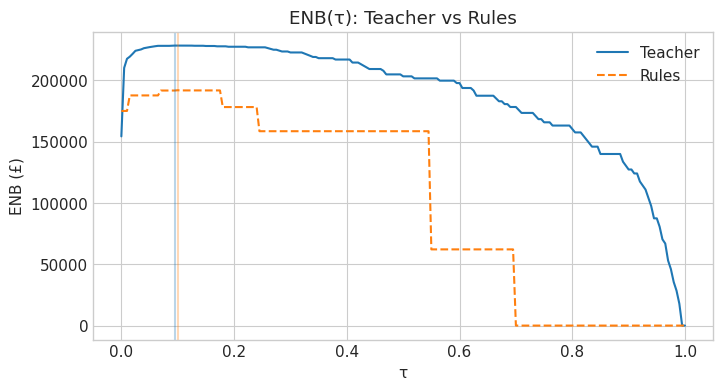

In [66]:
# Part B: Surrogate Rule Set

# Teacher score
p_tr = clf.predict_proba(pre.transform(X_train_raw))[:,1]
p_te = p_best
allow_raw = [
    "incident_severity","policy_annual_premium","claim_to_premium_ratio",
    "policy_tenure_days","months_as_customer","age","total_claim_amount",
    "vehicle_claim","property_claim","umbrella_limit",
    "incident_hour_of_the_day","bodily_injuries","witnesses","auto_year"
]
feat_all = pre.get_feature_names_out()

# one-hot
mask_allow = np.array([any(f.startswith(a) for a in allow_raw) for f in feat_all])

Xtr_num = pre.transform(X_train_raw)
Xte_num = pre.transform(X_test_raw)

Xtr_sel = Xtr_num[:, mask_allow]
Xte_sel = Xte_num[:, mask_allow]
feat_sel = feat_all[mask_allow]

# surrogate overfitting prevention
tree_1 = DecisionTreeRegressor(
    max_depth=3,
    min_samples_leaf=50,
    random_state=RANDOM_STATE
)
tree_1.fit(Xtr_sel, p_tr)

# performance
p_rule_tr = tree_1.predict(Xtr_sel)
p_rule_te = tree_1.predict(Xte_sel)

fid_r2   = r2_score(p_te, p_rule_te)
fid_spr  = spearmanr(p_te, p_rule_te).correlation


ap_teacher = average_precision_score(y_test, p_te)
ap_rule    = average_precision_score(y_test, p_rule_te)



def topk(y, p, ks=(50,100,200), r = b_scenario["r"], c = b_scenario["c"]):
    df = pd.DataFrame({"y":y, "p":p}).sort_values("p", ascending=False)
    P = y.sum()
    rows=[]
    for K in ks:
        sub = df.head(K)
        tp = int(sub["y"].sum()); fp = K - tp
        prec = tp/max(K,1); rec = tp/max(P,1)
        enb = r*sub["p"].sum() - c*K
        rows.append({"K":K,"TP":tp,"FP":fp,"Precision":prec,"Recall":rec,"ENB":enb})
    return pd.DataFrame(rows)

def enb_curve(y, p, r=b_scenario["r"], c=b_scenario["c"], n=201):
    ts = np.linspace(0, 1, n)
    enb_values = np.array([ r*float(p[p>=t].sum()) - c*int((p>=t).sum()) for t in ts ])
    i = int(enb_values.argmax())
    return ts, enb_values, float(ts[i]), float(enb_values[i])

ts_t, enb_t, tstar_t, enbmax_t = enb_curve(y_test, p_te)
ts_r, enb_r, tstar_r, enbmax_r = enb_curve(y_test, p_rule_te)

print(f"\nFidelity — R²={fid_r2:.3f}, Spearman={fid_spr:.3f}")
print(f"PR-AUC — Teacher={ap_teacher:.3f} | Rules={ap_rule:.3f}")
print(f"ENB max — Teacher=£{enbmax_t:,.0f} @ τ*={tstar_t:.3f} | Rules=£{enbmax_r:,.0f} @ τ*={tstar_r:.3f}")

print("\nTop-K — Teacher")
print(topk(y_test, p_te).round(4))
print("\nTop-K — Rules")
print(topk(y_test, p_rule_te).round(4))

#  rule,coverage
print("\n--- [Output B-1] Business Rules (depth<=3, min_leaf=50) ---")
print(export_text(tree_1, feature_names=list(feat_sel)))

# by leaf
leaf_id = tree_1.apply(Xte_sel)
leaf_df = pd.DataFrame({"leaf":leaf_id, "y":y_test, "p_teacher":p_te, "p_rule":p_rule_te})
rule_table = leaf_df.groupby("leaf").agg(
    coverage=("y","size"),
    fraud_rate=("y","mean"),
    mean_p_teacher=("p_teacher","mean"),
    mean_p_rule=("p_rule","mean")
).reset_index().sort_values("coverage", ascending=False)
rule_table["coverage_pct"] = rule_table["coverage"]/len(y_test)

print("\n--- [Output B-2] Rule coverage table ---")
print(rule_table.round(4))

# plots
plt.figure(figsize=(8,4))
plt.plot(ts_t, enb_t, label="Teacher")
plt.plot(ts_r, enb_r, label="Rules", linestyle="--")
plt.axvline(tstar_t, color="#1f77b4", alpha=.3)
plt.axvline(tstar_r, color="#ff7f0e", alpha=.3)
plt.title("ENB(τ): Teacher vs Rules")
plt.xlabel("τ"); plt.ylabel("ENB (£)")
plt.legend(); plt.grid(True); plt.show()


The surrogate model demonstrates a strong fidelity to the original LGBM model. A Spearman correlation of 0.628 indicates that the simple rule set maintains a similar risk ranking for claims, while an R² of 0.464 shows it explains a substantial portion of the more complex model's variance. This confirms that the surrogate is a reasonable and effective approximation of the 'teacher' model's logic.

When evaluated on the fraud detection task, the surrogate model provides a clear illustration of the trade-off between performance and interpretability. The rules-based approach resulted in a PR-AUC of 0.533, a modest decrease from the original model's 0.603. Similarly, the maximum Expected Net Benefit was £95,987, approximately 84% of the value captured by the more complex LGBM model. This analysis provides a quantitative framework for the business to decide whether the significant gains in transparency and ease of deployment justify the measured sacrifice in predictive performance.

The primary output of the surrogate analysis is a set of simple, actionable business rules. For example, the model identified that claims with high incident_severity combined with high bodily_injuries are assigned a very high fraud propensity score (0.70). These rules can be directly implemented in legacy claims systems or used as a training guide for junior investigators, bridging the gap between a complex machine learning model and day-to-day business operations.


To enhance interpretability, these thresholds should have been mapped in practice to enhance readability for business users.

# Error Decomposition

policy_tenure_days, claim_to_premium_ratio, incident_severity 슬라이스

In [67]:
# Stage 2C: Error Decomposition & Checklist

y_true  = y_test.values

ts = np.linspace(0, 1, 201)
enb = np.array([BASE_R * p_best[p_best>=t].sum() - BASE_C * (p_best>=t).sum() for t in ts])
tau_star = float(ts[enb.argmax()])

pred = (p_best >= tau_star).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()

df_te = X_test_raw.copy().reset_index(drop=True)
df_te["y"] = y_true
df_te["proba"] = p_best
df_te["pred"]  = pred
df_te["err"]   = np.where((df_te["y"]==1)&(df_te["pred"]==0), "FN",
                   np.where((df_te["y"]==0)&(df_te["pred"]==1), "FP", "OK"))

print(f"τ* = {tau_star:.3f} | CM: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

# feature analysis
num_feats = ["policy_annual_premium","property_claim","policy_tenure_days","claim_to_premium_ratio","total_claim_amount"]
cat_feats = ["incident_severity"]

def safe_bin(s, q=4):
    s = pd.to_numeric(s, errors="coerce")
    uniq = s.dropna().unique()
    if len(uniq) < q:
        return pd.cut(s, bins=min(q, max(2,len(uniq))), include_lowest=True)
    try:
        return pd.qcut(s, q, duplicates="drop")
    except Exception:
        return pd.cut(s, bins=q, include_lowest=True)

def err_slice_table(df, kind="FN"):
    """conditional error rate:
       - FN rate = FN / (actual positives) within slice
       - FP rate = FP / (actual negatives) within slice
    """
    rows=[]
    N = len(df)

    for col in [c for c in num_feats if c in df.columns]:
        bins = safe_bin(df[col])
        tmp = pd.DataFrame({
            "bin": bins.astype(str),
            "y": df["y"].values,
            "is_err": (df["err"]==kind).astype(int),
            "amt": df["total_claim_amount"] if "total_claim_amount" in df.columns else 0.0
        })

        if kind=="FN":
            denom = tmp.groupby("bin")["y"].sum()                        # positive
        else:
            denom = tmp.groupby("bin").apply(lambda g: (g["y"]==0).sum()) # negative
        g = tmp.groupby("bin").agg(
            count_all=("is_err","size"),
            error_count=("is_err","sum"),
            mean_amount=("amt","mean")
        ).reset_index()
        g["feature"] = col
        g = g.merge(denom.rename("denom"), on="bin", how="left")
        g["denom"] = g["denom"].clip(lower=1)
        g["error_rate"] = g["error_count"] / g["denom"]
        g["share_of_test"] = g["count_all"] / N
        rows.append(g[["feature","bin","count_all","denom","error_count","error_rate","mean_amount","share_of_test"]])

    # categorial
    for col in [c for c in cat_feats if c in df.columns]:
        tmp = pd.DataFrame({
            "bin": df[col].astype(str),
            "y": df["y"].values,
            "is_err": (df["err"]==kind).astype(int),
            "amt": df["total_claim_amount"] if "total_claim_amount" in df.columns else 0.0
        })
        if kind=="FN":
            denom = tmp.groupby("bin")["y"].sum()
        else:
            denom = tmp.groupby("bin").apply(lambda g: (g["y"]==0).sum())
        g = tmp.groupby("bin").agg(
            count_all=("is_err","size"),
            error_count=("is_err","sum"),
            mean_amount=("amt","mean")
        ).reset_index()
        g["feature"] = col
        g = g.merge(denom.rename("denom"), on="bin", how="left")
        g["denom"] = g["denom"].clip(lower=1)
        g["error_rate"] = g["error_count"] / g["denom"]
        g["share_of_test"] = g["count_all"] / N
        rows.append(g[["feature","bin","count_all","denom","error_count","error_rate","mean_amount","share_of_test"]])

    if not rows:
        return pd.DataFrame(columns=["feature","bin","count_all","denom","error_count","error_rate","mean_amount","share_of_test"])
    out = pd.concat(rows, axis=0, ignore_index=True).sort_values(["feature","error_rate"], ascending=[True,False])
    out["kind"] = kind
    return out

tab_fn = err_slice_table(df_te, "FN")
tab_fp = err_slice_table(df_te, "FP")

print("\n--- [Tab S2-5] FN Decomposition (conditional rates) ---")
print(tab_fn.head(12).round(4))
print("\n--- [Tab S2-6] FP Decomposition (conditional rates) ---")
print(tab_fp.head(12).round(4))


def checklist(tbl, kind="FN", topn=3):
    lines=[]
    base = (df_te["y"].mean() if kind=="FN" else 1-df_te["y"].mean())
    for _, r in tbl.sort_values("error_rate", ascending=False).head(topn).iterrows():
        lift = r["error_rate"]/base if base>0 else np.nan
        lines.append(
            f"- {kind}: [{r['feature']}] bin={r['bin']} | rate={r['error_rate']:.2f} (lift×{lift:.1f}), "
            f"coverage={r['share_of_test']*100:.1f}%, mean_amount={r['mean_amount']:.0f}"
        )
    return "\n".join(lines)

print("\nSuggested checklist (put into report):")
print(checklist(tab_fn, "FN"))
print(checklist(tab_fp, "FP"))

τ* = 0.095 | CM: TP=60, FP=35, FN=14, TN=191

--- [Tab S2-5] FN Decomposition (conditional rates) ---
                   feature                  bin  count_all  denom  \
12  claim_to_premium_ratio     (0.0665, 32.789]         75     10   
14  claim_to_premium_ratio     (45.743, 56.056]         75     24   
13  claim_to_premium_ratio     (32.789, 45.743]         75     19   
15  claim_to_premium_ratio    (56.056, 140.606]         75     21   
23       incident_severity       Trivial Damage         28      2   
21       incident_severity         Minor Damage        107     15   
22       incident_severity           Total Loss         85      7   
20       incident_severity         Major Damage         80     50   
0    policy_annual_premium  (1090.568, 1251.62]         75     16   
3    policy_annual_premium  (566.109, 1090.568]         75     22   
1    policy_annual_premium  (1251.62, 1443.988]         75     20   
2    policy_annual_premium  (1443.988, 1969.63]         75     16   



The error decomposition reveals a critical vulnerability in the model's logic: it struggles to identify fraud in low-severity incidents. This suggests that the patterns of 'soft fraud' (claim padding on minor incidents) are fundamentally different from those of 'hard fraud' (major fabricated events). To mitigate this risk, the investigation workflow should include a dedicated, separate review process for a random sample of low-severity, low-score claims. This 'adversarial audit' would help uncover these hidden fraud patterns and provide new data to retrain and improve the model over time.

The analysis of False Positives reveals that the model is overly sensitive to claims with high incident severity, leading to a high rate of incorrect fraud accusations in 'Major Damage' cases. This insight can be used to create a more nuanced investigation workflow. For claims that are flagged as high-risk and have an incident_severity of 'Major Damage', the system should not immediately trigger a fraud investigation. Instead, it should first trigger an automated request for supplementary evidence, such as a police report or a third-party damage assessment. Only if this supplementary evidence is missing or contradictory should the claim be escalated to the Special Investigations Unit (SIU). This creates a 'cooling-off' period that reduces false positives and protects legitimate customers who have suffered a serious loss.

# Cluster(test)

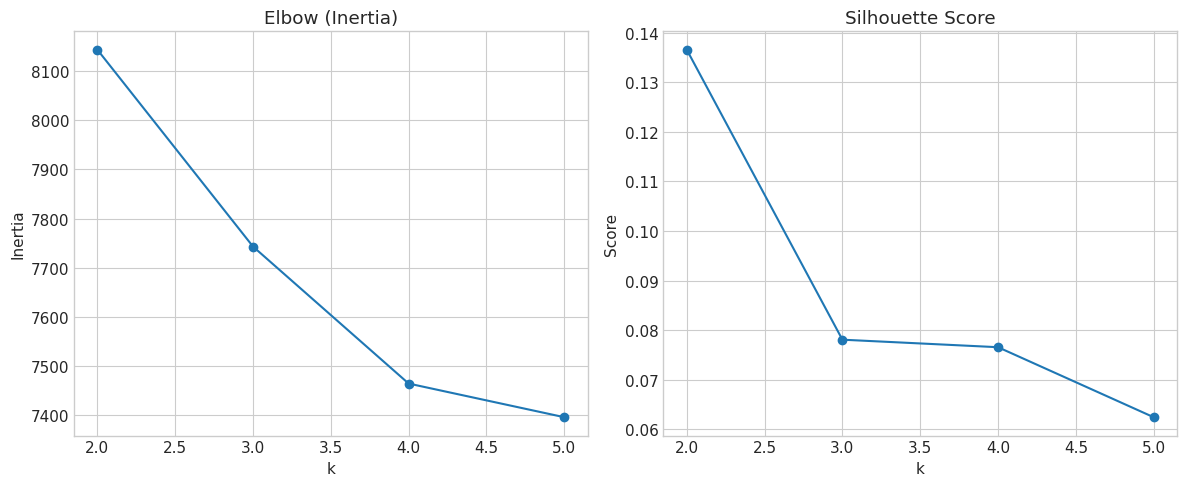

Silhouette Score (k=3): 0.0781
Cluster sizes: 0    128
1    117
2     55
Name: count, dtype: int64


In [68]:
from sklearn.cluster import KMeans

# transform raw data (X_test_raw or fraud-only subset if you want)
X_proc = pre.transform(X_test_raw)


# 2) Clustering (toy test)

k_range = range(2,6)
inertia = []
silhouette = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_proc)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(X_proc, labels))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_range, silhouette, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k"); plt.ylabel("Score")

plt.tight_layout()
plt.show()


best_k = 3  #


km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE)
labels = km.fit_predict(X_proc)

sil = silhouette_score(X_proc, labels)
print(f"Silhouette Score (k={best_k}): {sil:.4f}")
print("Cluster sizes:", pd.Series(labels).value_counts())

In [69]:
file_path2 = '/content/drive/MyDrive/Motor vehicle insurance data.csv'
motor_df = pd.read_csv(file_path2, sep=';')

A fraud detection model is not a simple 'yes/no' machine. Its true value lies in understanding its patterns of success and failure. By analyzing the model's errors, we have developed a more intelligent, two-pronged investigation strategy: a dedicated audit process for the subtle, low-severity frauds the model tends to miss, and an evidence-gathering buffer for the legitimate, high-severity claims the model tends to wrongly accuse. This error-driven refinement is the key to moving from a purely statistical tool to a truly intelligent business process.

# Calibration Test

In [70]:
# Appendix – Calibration check (do not use for main results)

p_uncal = p_best


Xt_tr = pre.fit_transform(X_train_raw, y_train)
Xt_te = pre.transform(X_test_raw)


def make_calibrator(est):
    return CalibratedClassifierCV(estimator=clone(est), method="isotonic", cv=3)

cal = make_calibrator(clf)
cal.fit(Xt_tr, y_train)
p_cal = cal.predict_proba(Xt_te)[:, 1]

# index
ap_uncal = average_precision_score(y_test, p_uncal)
ap_cal   = average_precision_score(y_test, p_cal)
br_uncal = brier_score_loss(y_test, p_uncal)
br_cal   = brier_score_loss(y_test, p_cal)

print(f"PR-AUC  uncal = {ap_uncal:.4f} | cal = {ap_cal:.4f}")
print(f"Brier   uncal = {br_uncal:.4f} | cal = {br_cal:.4f}")

# enb curve
def enb_curve(y, p, r=b_scenario["r"], c=b_scenario["c"], n=201):
    ts = np.linspace(0, 1, n)
    enb = np.array([ r*float(p[p>=t].sum()) - c*int((p>=t).sum()) for t in ts ])
    i = int(enb.argmax())
    return ts, enb, float(ts[i]), float(enb[i])

ts_u, enb_u, t_u, enbmax_u = enb_curve(y_test, p_uncal)
ts_c, enb_c, t_c, enbmax_c = enb_curve(y_test, p_cal)

print(f"ENB max (uncal) = {enbmax_u:,.1f} at τ*={t_u:.3f}")
print(f"ENB max (cal)   = {enbmax_c:,.1f} at τ*={t_c:.3f}")



# Top-K
def topk(y, p, ks=(50,100,200), r=b_scenario["r"], c=b_scenario["c"]):
    df = pd.DataFrame({'y':y.values, 'p':p}).sort_values('p', ascending=False)
    rows=[]
    P = int((y==1).sum())
    for K in ks:
        sub = df.head(K)
        tp = int(sub['y'].sum()); fp = K - tp
        prec = tp / max(K,1); rec = tp / max(P,1)
        enb = r*sub['p'].sum() - c*K
        rows.append({'K':K,'TP':tp,'FP':fp,'Precision':prec,'Recall':rec,'ENB':enb})
    return pd.DataFrame(rows)

print("\nTop-K (Uncal):")
print(topk(y_test, p_uncal).round(4))
print("\nTop-K:")
print(topk(y_test, p_cal).round(4))

PR-AUC  uncal = 0.6029 | cal = 0.5393
Brier   uncal = 0.1376 | cal = 0.1365
ENB max (uncal) = 228,396.0 at τ*=0.095
ENB max (cal)   = 180,376.0 at τ*=0.100

Top-K (Uncal):
     K  TP   FP  Precision  Recall          ENB
0   50  31   19       0.62  0.4189  165811.6939
1  100  61   39       0.61  0.8243  228187.1509
2  200  66  134       0.33  0.8919  194028.7748

Top-K:
     K  TP   FP  Precision  Recall          ENB
0   50  32   18       0.64  0.4324  100301.4343
1  100  58   42       0.58  0.7838  159981.1652
2  200  62  138       0.31  0.8378  179706.4134


Although probability calibration (e.g., isotonic regression) was briefly tested,
it was excluded from the main analysis. While calibration slightly improved
the Brier score (probability reliability), it consistently reduced the
Expected Net Benefit (ENB), which is the primary metric of decision utility
in this study. Therefore, all Stage 2 analyses are reported using
the uncalibrated probabilities. Full calibration results are provided in Appendix C.

This finding demonstrates that while probability calibration can improve reliability of scores, it may reduce decision-centric utility in fraud detection. For operational deployment, ENB should be prioritised over purely statistical calibration.”